In [2]:
import pandas as pd
from sqlalchemy import create_engine
import dotenv
import os
from tabulate import tabulate
import mplsoccer
import matplotlib.pyplot as plt

dotenv.load_dotenv()

PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_USER = os.getenv("PG_USER")
PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DATABASE = os.getenv("PG_DB")

# SQLAlchemy engine
engine = create_engine(
    f"postgresql+psycopg2://{PG_USER}:{PG_PASSWORD}@{PG_HOST}:{PG_PORT}/{PG_DATABASE}?sslmode=require"
)

# Create a connection object from the engine
conn = engine.connect()

In [3]:

def get_table_names():
    query = """
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'public'
    """
    df = pd.read_sql(query, conn)
    return df["table_name"].tolist()

get_table_names()


['eventtypes',
 'matches',
 'matchevents',
 'player_tracking',
 'players',
 'qualifiers',
 'qualifiertypes',
 'spadl_actions',
 'teams',
 'role_passwords']

In [4]:
def get_table_info(table_name):
    query = f"""
    SELECT column_name, data_type
    FROM information_schema.columns
    WHERE table_name = '{table_name}'
    """
    df = pd.read_sql(query, conn)
    print(tabulate(df, headers="keys", tablefmt="psql"))

get_table_info("matches")

+----+---------------+-----------------------------+
|    | column_name   | data_type                   |
|----+---------------+-----------------------------|
|  0 | match_id      | character varying           |
|  1 | match_date    | timestamp without time zone |
|  2 | home_team_id  | character varying           |
|  3 | away_team_id  | character varying           |
|  4 | home_score    | integer                     |
|  5 | away_score    | integer                     |
+----+---------------+-----------------------------+


In [5]:
def get_table_rows(table_name):
    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql(query, conn)
    return df
get_table_rows("matches")


,match_id,match_date,home_team_id,away_team_id,home_score,away_score
0,5oc8drrbruovbuiriyhdyiyok,2024-07-26,1oyb7oym5nwzny8vxf03szd2h,b7jmo07lqav0wfe2mtlzyspak,1,1
1,5r7lyj3frtml3aqy458jrxj4k,2024-07-28,920raeoumft3q2wmvc296uceo,7zibyotq1x1hq6pmgibhr0e6s,0,1
2,5ptnar4qtaltvcfsjdw9vzhg4,2024-07-27,6vyr13j6kbwdtxjwm1m4m8nu2,2989v3kho9h5jaboe1nr7lx21,1,0
3,5qqz2do47zjms7rfrwzcths7o,2024-07-28,1uk609mhtsfhokhaewjapb26,8y3iucyxguipljcmf87a11bk9,0,1
4,5pcyhm34h5c948yji4oryevpw,2024-07-27,cyrrlv6l1onld5x247w1q1jlr,bw9wm8pqfzcchumhiwdt2w15c,0,0
...,...,...,...,...,...,...
141,77w03jwg8cs1dkqemcax540t0,2024-12-13,b7jmo07lqav0wfe2mtlzyspak,7zibyotq1x1hq6pmgibhr0e6s,1,1
142,789p8p9wchivsno0m437haeqc,2024-12-15,2989v3kho9h5jaboe1nr7lx21,6vyr13j6kbwdtxjwm1m4m8nu2,0,2
143,78nndczlbj2214zhtbfahs2s4,2024-12-22,ecj1gmc7pqcjo4sc9hvghj5u3,1oyb7oym5nwzny8vxf03szd2h,2,2
144,791cri1kfsl6c1h5ozv0iqcyc,2024-12-22,89xivtxk59uzvhdsd6miao6tm,6vyr13j6kbwdtxjwm1m4m8nu2,2,0


In [6]:
tables = get_table_names()

# count all rows in all tables
def get_row_count(table_name):
    query = f"SELECT COUNT(*) FROM {table_name}"
    df = pd.read_sql(query, conn)
    return df.iloc[0, 0]
row_counts = {}

for table in tables:
    row_counts[table] = get_row_count(table)
row_counts


{'eventtypes': np.int64(36),
 'matches': np.int64(146),
 'matchevents': np.int64(218848),
 'player_tracking': np.int64(18510936),
 'players': np.int64(487),
 'qualifiers': np.int64(106049),
 'qualifiertypes': np.int64(41),
 'spadl_actions': np.int64(242450),
 'teams': np.int64(16),
 'role_passwords': np.int64(129)}

# Where do unoccupied spaces regularly appear in defense?
Helps detect consistent blind spots. Useful for adjusting positioning or player roles

In [7]:
print("Info about match events table:")
get_table_info("matchevents")
print("There is a timestamp column in the match events table.")
print("\n")

print("Info about player tracking table:")
get_table_info("player_tracking")
print("There is a timestamp column in the player tracking table.")
print("\n")

print("We can map the timestamps to see where the players are when the other team is doing attacking events.")

Info about match events table:
+----+--------------------+-------------------+
|    | column_name        | data_type         |
|----+--------------------+-------------------|
|  0 | match_id           | character varying |
|  1 | event_id           | character varying |
|  2 | eventtype_id       | character varying |
|  3 | result             | character varying |
|  4 | success            | boolean           |
|  5 | period_id          | integer           |
|  6 | timestamp          | character varying |
|  7 | end_timestamp      | character varying |
|  8 | ball_state         | character varying |
|  9 | ball_owning_team   | character varying |
| 10 | team_id            | character varying |
| 11 | player_id          | character varying |
| 12 | x                  | double precision  |
| 13 | y                  | double precision  |
| 14 | end_coordinates_x  | double precision  |
| 15 | end_coordinates_y  | double precision  |
| 16 | receiver_player_id | character varying |
+----+---

/Users/iannauwelaers/Documents/School/2024-2025/Semester2/Advanced_AI/InternationalWeek/soccer_analytics_projectweek/.venv/lib/python3.13/site-packages/mplsoccer/heatmap.py:135: RuntimeWarning: invalid value encountered in divide
  statistic = statistic / statistic.sum()


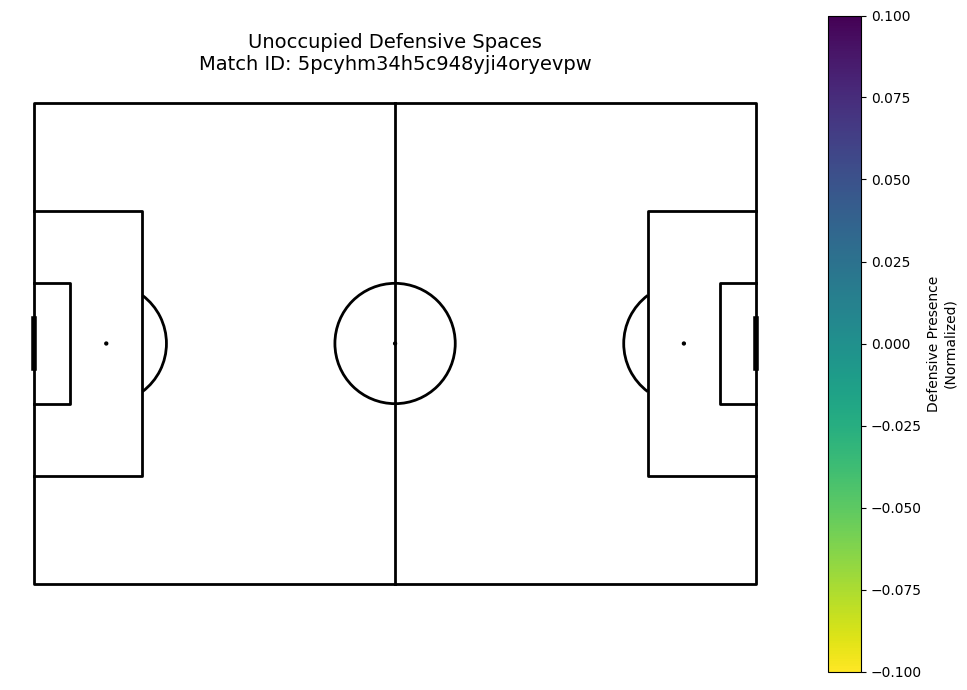

In [8]:
def unoccupied_defensive_spaces(match_id, our_team_id):
    # Step 1: Load only data for the selected match
    events_query = f"SELECT * FROM matchevents WHERE match_id = '{match_id}'"
    events_df = pd.read_sql(events_query, conn)

    tracking_query = f"SELECT * FROM player_tracking WHERE game_id = '{match_id}'"
    tracking_df = pd.read_sql(tracking_query, conn)

    # Step 2: Get timestamps when the opponent is attacking
    opponent_attack_events = events_df[events_df["ball_owning_team"] != our_team_id]
    opponent_timestamps = opponent_attack_events["timestamp"].unique()

    # Step 3: Get your team's player_ids (active in the match)
    our_players = events_df[
        (events_df["team_id"] == our_team_id) &
        (events_df["player_id"].notnull())
    ]["player_id"].unique()

    # Step 4: Filter player tracking data during opponent attacks
    our_tracking_during_defense = tracking_df[
        (tracking_df["player_id"].isin(our_players)) &
        (tracking_df["timestamp"].isin(opponent_timestamps))
    ]

    # Step 5: Plot heatmap of defensive positions
    pitch = mplsoccer.Pitch(pitch_type='statsbomb', pitch_color='white', line_color='black')
    fig, ax = pitch.draw(figsize=(10, 7))

    x = our_tracking_during_defense["x"].values
    y = our_tracking_during_defense["y"].values

    bin_statistic = pitch.bin_statistic(x, y, statistic='count', bins=(30, 20), normalize=True)
    pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='viridis_r')  # brighter = less presence

    # Add colorbar
    fig.colorbar(pcm, ax=ax, label='Defensive Presence\n(Normalized)')

    # Title
    ax.set_title(f"Unoccupied Defensive Spaces\nMatch ID: {match_id}", fontsize=14)

    plt.show()

unoccupied_defensive_spaces(match_id="5pcyhm34h5c948yji4oryevpw", our_team_id="bw9wm8pqfzcchumhiwdt2w15c")
